In [125]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Data cleaning

In [701]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")

In [703]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]


In [705]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [707]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

## Generating synthetic data

### Feature selection

In [711]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts']
subset_balance = balance_df.loc[:,required_features2]

### Data Cleaning

In [714]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts':"No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

# Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])


### Savings

In [717]:
from sklearn.cluster import KMeans

original_copy = original
sav = pd.read_csv("../data/credit_score.csv") 
# https://www.kaggle.com/datasets/conorsully1/credit-score?resource=download

# convert income into income category then one-hot encoding
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
sav['Income_Category'] = pd.cut(sav['INCOME'], bins = bins, labels = labels, right = False)
sav = pd.get_dummies(sav, columns=['Income_Category'], drop_first=True)

# clustering
features = sav[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']]

kmeans = KMeans(n_clusters=3, n_init = 10)
sav['Cluster'] = kmeans.fit_predict(features)

# fitting normal distribution
stats = sav.groupby('Cluster')['SAVINGS'].agg(['mean', 'std']).reset_index()
stats.columns = ['Cluster', 'Mean', 'SD']

def sample(cluster):
    mean = stats.loc[stats['Cluster'] == cluster, 'Mean'].values[0]
    sd = stats.loc[stats['Cluster'] == cluster, 'SD'].values[0]
    return round(max(np.random.normal(mean, sd), 0), 2) #avoid savings being negative & change to 2 decimal places

sav['Savings'] = sav['Cluster'].apply(sample)

# fitting into original
original_copy = pd.get_dummies(original_copy, columns=['Income_Category'], drop_first = False)
original_copy['Cluster'] = kmeans.predict(original_copy[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']])
original_copy['Savings'] = original_copy['Cluster'].apply(sample)
original['Savings'] = original_copy['Savings']

### Fitting model, KMEANS

### Fee Sensitivity

In [721]:
fake = Faker()

def generate_fake_data(num_samples):
    fake_data = []
    for _ in range(num_samples):
        loan_amount = np.random.randint(100, 10000)  # Random loan amount between 100 and 10,000
        account_balance = np.random.randint(0, 20000)  # Random balance between 0 and 20,000
        fee_sensitivity = np.random.uniform(1.0, 5.0)  # Random fee sensitivity between 1 and 5
        fake_data.append({
            'fee_sensitivity': fee_sensitivity,
            'outstanding_loan': loan_amount,
            'account_balance': account_balance
        })
    return pd.DataFrame(fake_data)

new_data = generate_fake_data(100)

# Clustering
kmeans = KMeans(n_clusters=3)  # I chose 3 clusters
new_data['cluster'] = kmeans.fit_predict(new_data[['fee_sensitivity']])

# Normal distributions for each cluster
clusters_stats = {}
for cluster in new_data['cluster'].unique():
    cluster_data = new_data[new_data['cluster'] == cluster]
    mean_loan = cluster_data['outstanding_loan'].mean()
    std_loan = cluster_data['outstanding_loan'].std()
    mean_balance = cluster_data['account_balance'].mean()
    std_balance = cluster_data['account_balance'].std()
    clusters_stats[cluster] = {
        'outstanding_loan': (mean_loan, std_loan),
        'account_balance': (mean_balance, std_balance)
    }


def sample_fake_data(row):
    # Assume a placeholder for fee sensitivity since it's not in original
    cluster_label = kmeans.predict([[row.get('fee_sensitivity', np.nan)]])[0]
    mean_loan, std_loan = clusters_stats[cluster_label]['outstanding_loan']
    mean_balance, std_balance = clusters_stats[cluster_label]['account_balance']
    
    # Sample from the normal distribution
    sampled_loan = np.random.normal(mean_loan, std_loan)
    sampled_balance = np.random.normal(mean_balance, std_balance)
    
    return pd.Series([sampled_loan, sampled_balance])

# Add fake data to the original dataset
original[['sampled_outstanding_loan', 'sampled_account_balance']] = original.apply(sample_fake_data, axis=1)

print(original.head())

/Users/liviajaison/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liviajaison/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Campaign Effectiveness

In [724]:
campaign = pd.read_csv("../data/campaign_data.csv", sep = ';') 
# https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets?select=test.csv
# training data was used since it was much larger than test data (randomly selected rows from training data)

# data that will be added
# campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
# pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
# previous: number of contacts performed before this campaign and for this client (numeric)
# poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
# y - has the client subscribed a term deposit? (binary: "yes","no")

# campaign (using normal d/b)
np.random.seed(10) # setting seed for reproducibility
mean_campaign = campaign['campaign'].mean()
sd_campaign = campaign['campaign'].std()
n = len(original)
original['Num_of_Contacts_Made'] = np.random.normal(mean_campaign, sd_campaign, n)
original['Num_of_Contacts_Made'] = np.round(np.maximum(original['Num_of_Contacts_Made'], 0), 0)

# pdays (using normal d/b)
np.random.seed(10) # setting seed for reproducibility
mean_pdays = campaign['pdays'].mean()
sd_pdays = campaign['pdays'].std()
original['Last_Contacted'] = np.random.normal(mean_pdays, sd_pdays, n)
original['Last_Contacted'] = np.round(np.maximum(original['Last_Contacted'], -1), 0)

# previous (using normal d/b)
np.random.seed(10) # setting seed for reproducibility
mean_previous = campaign['previous'].mean()
sd_previous = campaign['previous'].std()
original['Last_Campaign_Contact'] = np.random.normal(mean_previous, sd_previous, n)
original['Last_Campaign_Contact'] = np.round(np.maximum(original['Last_Campaign_Contact'], 0), 0)

# poutcomes
poutcome_counts = campaign['poutcome'].value_counts()
poutcomes = poutcome_counts.index
n_campaign = len(campaign)
p_poutcome = (poutcome_counts/n_campaign).tolist()
original['Last_Campaign_Outcome'] = np.random.choice(poutcomes, size = n, p = p_poutcome)

# y 
y_counts = campaign['y'].value_counts()
y_outcomes = y_counts.index
p_y = (y_counts/n_campaign).tolist()
original['Outcome'] = np.random.choice(y_outcomes, size = n, p = p_y)

### Digital Banking Behaviour

Dataset: https://www.kaggle.com/datasets/mikhail1681/user-churn

relevant features: PhoneService, InternetService, TechSupport

In [727]:
original.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7081 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CLIENTNUM               7081 non-null   int64   
 1   Attrition_Flag          7081 non-null   category
 2   Customer_Age            7081 non-null   int64   
 3   Gender                  7081 non-null   category
 4   Dependent_count         7081 non-null   int64   
 5   Education_Level         7081 non-null   category
 6   Marital_Status          7081 non-null   category
 7   Income_Category         7081 non-null   category
 8   Card_Category           7081 non-null   category
 9   Month_with_bank         7081 non-null   int64   
 10  No_of_product           7081 non-null   int64   
 11  Months_Inactive_12_mon  7081 non-null   int64   
 12  Credit_Limit            7081 non-null   float64 
 13  Total_Revolving_Bal     7081 non-null   int64   
 14  Total_Trans_Amt         7081

In [729]:
print(original.head())

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
4  709106358  Existing Customer            40      M                3   
5  713061558  Existing Customer            44      M                2   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married         60 - 80          Blue   
1        Graduate         Single    Less than 40          Blue   
2        Graduate        Married        80 - 120          Blue   
4      Uneducated        Married         60 - 80          Blue   
5        Graduate        Married         40 - 60          Blue   

   Month_with_bank  ...  Total_Revolving_Bal  Total_Trans_Amt  \
0               39  ...                  777             1144   
1               44  ...           

In [731]:
technical = pd.read_csv("../data/User churn.csv")

# print(original.head())
# original.info()
technical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [733]:
# Define common features
common_features = ['gender', 'SeniorCitizen', 'Partner', 'Churn', 'Dependents']

# Calculate the distribution of PhoneService
phone_service_distribution = (
    technical.groupby(common_features)['PhoneService']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    technical.groupby(common_features)['InternetService']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    technical.groupby(common_features)['TechSupport']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

print(phone_service_distribution)
print(internet_service_distribution)
print(tech_support_distribution)


PhoneService                                         No       Yes
gender SeniorCitizen Partner Churn Dependents                    
Female 0             No      No    No          0.112211  0.887789
                                   Yes         0.154545  0.845455
                             Yes   No          0.076923  0.923077
                                   Yes         0.062500  0.937500
                     Yes     No    No          0.076763  0.923237
                                   Yes         0.096503  0.903497
                             Yes   No          0.131579  0.868421
                                   Yes         0.072581  0.927419
       1             No      No    No          0.075472  0.924528
                                   Yes         0.000000  1.000000
                             Yes   No          0.101266  0.898734
                                   Yes         0.000000  1.000000
                     Yes     No    No          0.044118  0.955882
          

In [735]:
original['gender'] = original['Gender'].apply(lambda x: 'Male' if x == 'M' else 'Female')
original['SeniorCitizen'] = (original['Customer_Age'] > 60).astype(int)
original['Partner'] = original['Marital_Status'].apply(lambda x: 'Yes' if x == 'Married' else 'No')
original['Dependents'] = original['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')
original['Churn'] = original['Attrition_Flag'].apply(lambda x: 'Yes' if x == 'Existing Customer' else 'No')

original.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Num_of_Contacts_Made,Last_Contacted,Last_Campaign_Contact,Last_Campaign_Outcome,Outcome,gender,SeniorCitizen,Partner,Dependents,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,7.0,174.0,4.0,other,no,Male,0,Yes,Yes,Yes
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,5.0,112.0,2.0,unknown,no,Female,0,No,Yes,Yes
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,0.0,-1.0,0.0,unknown,no,Male,0,Yes,Yes,Yes
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,3.0,39.0,1.0,unknown,no,Male,0,Yes,Yes,Yes
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,5.0,102.0,2.0,unknown,no,Male,0,Yes,Yes,Yes


In [737]:
def generate_synthetic_features(df, distribution, feature):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        
            # Use the distribution to sample
        sample = np.random.choice(
            distribution.columns,
            p=distribution.loc[features].values
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
original['PhoneService'] = generate_synthetic_features(original, phone_service_distribution, 'PhoneService')
original['InternetService'] = generate_synthetic_features(original, internet_service_distribution, 'InternetService')
original['TechSupport'] = generate_synthetic_features(original, tech_support_distribution, 'TechSupport')

original.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Last_Campaign_Outcome,Outcome,gender,SeniorCitizen,Partner,Dependents,Churn,PhoneService,InternetService,TechSupport
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,other,no,Male,0,Yes,Yes,Yes,Yes,DSL,No
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,unknown,no,Female,0,No,Yes,Yes,Yes,DSL,No
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,unknown,no,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,unknown,no,Male,0,Yes,Yes,Yes,Yes,No,Yes
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,unknown,no,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes


## What are the key factors influencing customer engagement with our marketing campaigns?

#### Analysing Historical Campaign Data

In [740]:
# change others/unknown into 0; failure into -1 and success into 1 (others/unknown become irrelevant) -> categorise Last_Campaign_Outcome
ori = original
ori['Last_Campaign_Outcome'] = ori['Last_Campaign_Outcome'].replace({
    'others': 0,
    'unknown': 0,
    'failure': -1,
    'success': 1
})
ori['Last_Campaign_Outcome'] = pd.to_numeric(ori['Last_Campaign_Outcome'], errors='coerce')

# the historical campaign data: ['Last_Contacted', 'Last_Campaign_Contact', 'Last_Campaign_Outcome']
ori[['Last_Contacted', 'Last_Campaign_Contact', 'Last_Campaign_Outcome']].corr()

,Last_Contacted,Last_Campaign_Contact,Last_Campaign_Outcome
Last_Contacted,1.000000,0.985111,-0.018020
Last_Campaign_Contact,0.985111,1.000000,-0.018192
Last_Campaign_Outcome,-0.018020,-0.018192,1.000000


The correlation matrix shows high correlation between Last_Contacted (number of days since last contact) and Last_Camapaign_Contact (number of contacts performed in the last contact). However, both of these have negative and low corrrelation with the outcome of the last campaign.
Thus, we can assume that these two variables did not affect the last campaign's outcome as much.

In [744]:
# observing correlation of selected columns
cols = ['Customer_Age', 'Income_Category', 'Card_Category', 'Month_with_bank', 'No_of_product',
        'Credit_Limit', 'Savings', 'SeniorCitizen', 'Churn', 'PhoneService', 'TechSupport', 'Last_Campaign_Outcome']
ori_cols = ori[cols]
# numerising all the variables
## Income_Category
ori_cols['Income_Category'] = ori_cols['Income_Category'].map(
    {'120 +': 5, 
     '40 - 60': 4, 
     '60 - 80': 3, 
     '80 - 120': 2, 
     'Less than 40': 1})
## Card_Category
ori_cols['Card_Category'] = ori_cols['Card_Category'].map(
    {'Blue': 1, 
     'Silver': 2,
     'Gold': 3,
     'Platinum': 4})
## Churn
ori_cols['Churn'] = ori_cols['Churn'].map({'No': 0, 'Yes': 1})
## PhoneService
ori_cols['PhoneService'] = ori_cols['PhoneService'].map({'No': 0, 'Yes': 1})
## TechSupport
ori_cols['TechSupport'] = ori_cols['TechSupport'].map({'No': 0, 'Yes': 1})

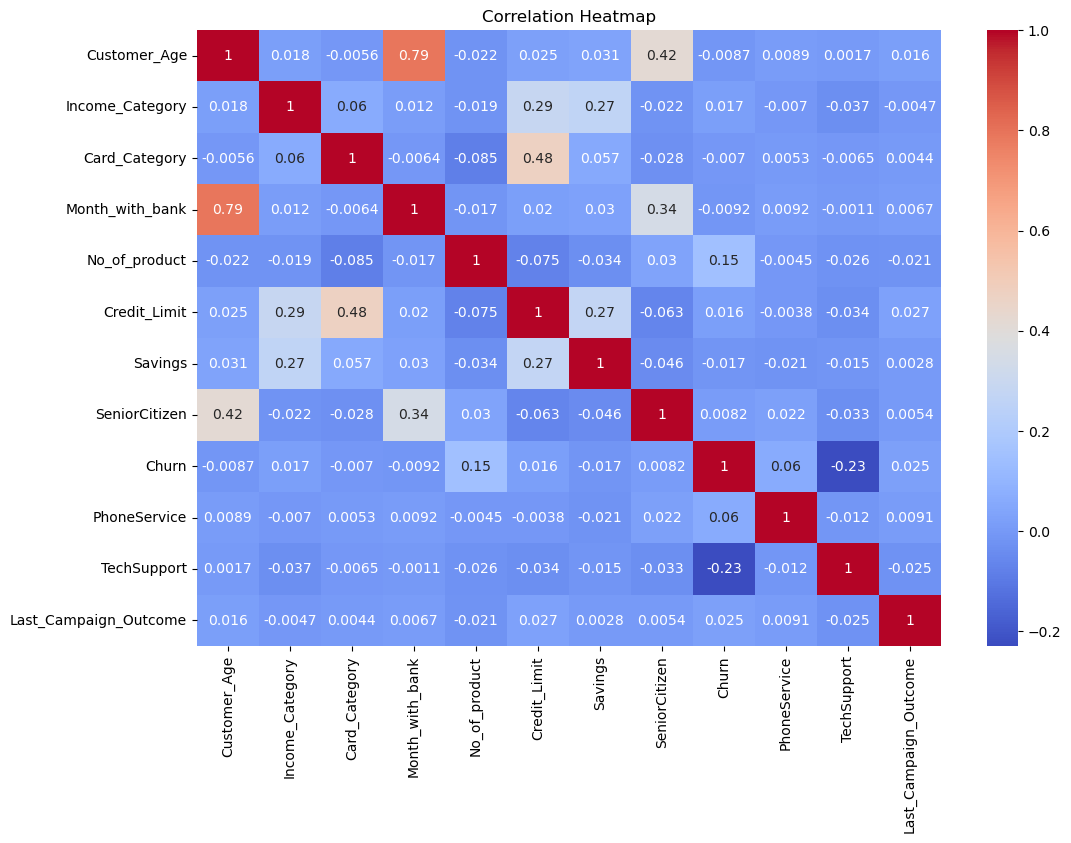

In [746]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ori_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Compared to the last campaign's outcome, there is little correlation with any of the other variables selected. The highest corrleations is for Credit Limit, Churn, Customer's Age. This could mean that people higher credit limit or people who are older will result in a postive outcome.

There is a negative correlation between number of products and last campaign's outcome suggesting that people with more products will less likely sign up for another one. 

The correlation heatmap and usage of correlation could not give observable realtionships because of the large number of unknown outcomes of the last campaign. Hence, the correlations are underrepresented because there is actually a greater number of successes.

In [749]:
X.head()

,Last_Contacted,Num_of_Contacts_Made,Months_Inactive_12_mon,Customer_Age,Total_Trans_Count,Total_Trans_Amt,Savings,Education_Level
1,112.0,5.0,1,49,33,1291,261714.71,NaN
2,-1.0,0.0,1,51,20,1887,612762.35,NaN
4,39.0,3.0,1,40,28,816,227888.66,NaN
5,102.0,5.0,1,44,24,1088,98206.41,NaN
8,-1.0,1.0,2,37,24,1350,54991.74,NaN


In [761]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# decision tree
np.random.seed(10)
ori['Education_Level'] = ori['Education_Level'].replace(
    {'Doctorate': 5,
     'Post-Graduate': 4,
     'Graduate': 3,
     'College': 2,
     'High School': 1, 
     'Uneducated': 0})
X = ori[['Last_Contacted', 'Num_of_Contacts_Made', 'Months_Inactive_12_mon', 'Customer_Age', 
         'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Education_Level']]
y = ori['Last_Campaign_Outcome']
#removing the NAs since Decision Trees cannot process NAs
mask = ~y.isnull()
X = X[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1, class_weight = 'balanced')
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

array([0., 0., 0., ..., 0., 0., 0.])

In [783]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Total_Trans_Amt,0.194815
Savings,0.169536
Total_Trans_Count,0.166883
Customer_Age,0.147969
Last_Contacted,0.123212
Education_Level,0.069904
Num_of_Contacts_Made,0.064930
Months_Inactive_12_mon,0.062751


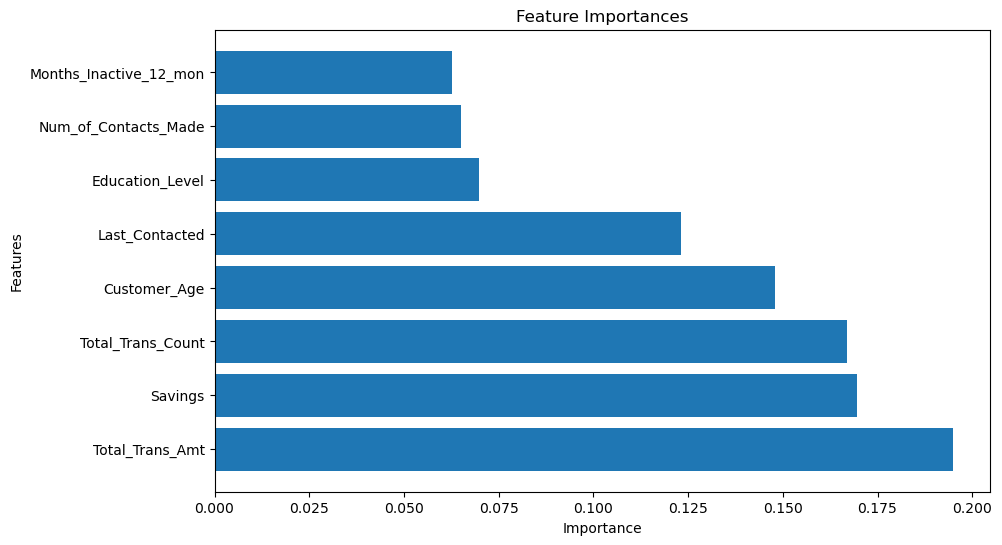

In [785]:
# Plotting the feature importances
plt.figure(figsize = (10, 6))
plt.title("Feature Importances")
plt.barh(impt.index, impt["Importance"], align="center")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

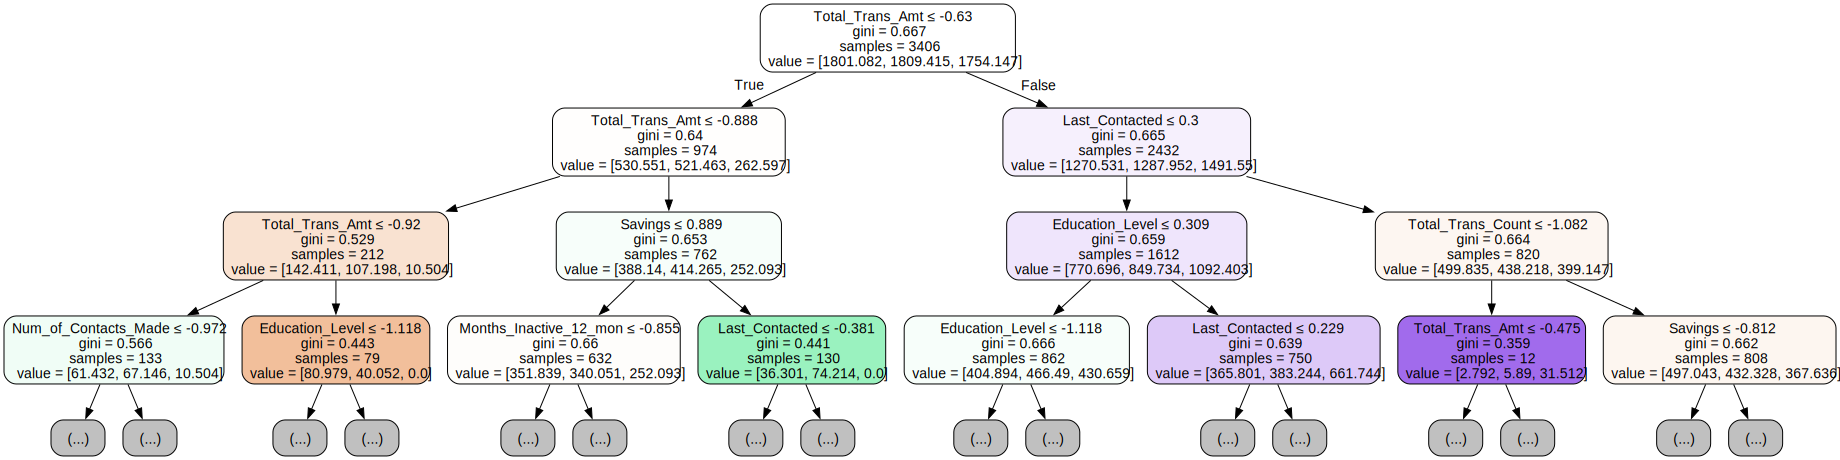

In [811]:
# the random forest
from sklearn.tree import export_graphviz
import graphviz
dotfile = export_graphviz(rf_model.estimators_[0], 
                          out_file = None, 
                          feature_names = X.columns,  
                          filled = True, rounded = True,  
                          special_characters = True,
                          max_depth = 3) # reducing the max_depth since the tree is large  
tree = graphviz.Source(dotfile)  
tree

### Propose metrics for tracking campaign effectiveness over time

##### Key Factors Influencing Customer Engagement
1) Customer Segmentation:
    - Digital Engagement Level: Customers who are highly digitally engaged (Segment 1) are more likely to respond positively to digital marketing campaigns through channels like emails, social media, or mobile apps. Low-engagement customers (Segment 3) might prefer more traditional outreach like direct mail.
    - Transaction History: High spenders/frequent users (Segment 4) are likely to engage more with promotions related to exclusive offers, loyalty programs, or high-end products. On the other hand, low spenders (Segment 6) might be motivated by discounts or cost-saving opportunities.
    - Financial Status: Customers with high financial standing (Segment 10) might be drawn to campaigns promoting investment opportunities, premium accounts, or wealth management services. Low financial standing customers (Segment 12) may engage more with campaigns focused on debt management, credit improvement, or lower-cost products.

2) Personalization:
    - Personalization is crucial across all segments. The more tailored a campaign is to a customer’s habits, needs, and preferences, the higher the likelihood of engagement. For instance, using customer data to send offers relevant to their transaction behavior, product usage, or financial status can greatly increase engagement.

3) Communication Channel:
    - Digital engagement levels directly influence the preferred channels for communication. Highly digitally engaged customers are more responsive to email, social media, or app notifications, while others may prefer direct mail or phone calls. 


##### Proposed Metrics for Tracking Campaign Effectiveness
1) Engagement Rate:
    - Tracks the overall interaction with campaigns (e.g., email opens, clicks). This is a key indicator of initial interest across all customer segments.
2) Conversion Rate:
    - Measures the percentage of customers who complete the desired action (e.g., purchase, sign-up), giving direct insight into campaign success.
3) Customer Lifetime Value (CLV):
    - Helps track long-term profitability and how successful campaigns are in retaining and increasing the value of customers over time.
4) Return on Marketing Investment (ROMI):
    - Shows the financial impact of campaigns by comparing revenue generated to campaign costs, ensuring resources are allocated efficiently.